# K-MUgen

### Assignment goals:
- Continuous, unconditioned generation: Similar to Option 1, but with continuous
output (i.e., generate a waveform). Note that if using a model that generates
spectrograms you must also render the spectrogram as a waveform.
- Continuous, conditioned generation: Example tasks include:
  - prompt-based generation (e.g. text-to-spectrogram)
  -  “inpainting” (replace part of an existing waveform/spectrogram) or “outpainting”
(extend an existing waveform/spectrogram)
  - continuous control (e.g. generate music that follows a given volume or pitch
curve)
  - synthesis of a symbolic input (i.e., midi-to-audio using a learned model)

## Continuous, unconditioned generation (TEMP)

K-pop Music Generation - Option 3: Continuous, Unconditioned Generation

WHAT THIS ACCOMPLISHES:
- Learns the distribution of K-pop music from your downloaded audio files
- Generates completely new K-pop-style melspectrograms from scratch
- Converts generated spectrograms back to playable audio
- Creates novel K-pop tracks that don't exist but sound authentic to the genre

APPROACH: VAE (Variational Autoencoder) for melspectrogram generation

### Installing Dependencies

In [22]:
# %pip install numpy
# %pip install librosa
# %pip install matplotlib
# %pip install torch
# %pip install soundfile
# %pip install pathlib
# %pip install pretty_midi


import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
from pathlib import Path
import pickle
import pretty_midi
import random

In [23]:
# ===== STEP 1: DATA PREPROCESSING =====

class MidiDataProcessor:
    def __init__(self, data_dir="./Data", 
                 sr=22050, n_mels=128, n_fft=2048, hop_length=512):
        self.data_dir = data_dir
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        
    def midi_to_audio(self, midi_path, duration=30):
        """Convert MIDI file to audio waveform"""
        try:
            # Load MIDI file
            midi_data = pretty_midi.PrettyMIDI(midi_path)
            
            # Synthesize audio
            audio = midi_data.synthesize(fs=self.sr)
            
            # Take a fixed-length segment (e.g., 30 seconds)
            segment_length = self.sr * duration
            if len(audio) > segment_length:
                # Take middle section
                start = (len(audio) - segment_length) // 2
                audio = audio[start:start + segment_length]
            else:
                # Pad if too short
                audio = np.pad(audio, (0, max(0, segment_length - len(audio))))
            
            return audio
            
        except Exception as e:
            print(f"Error processing {midi_path}: {e}")
            return None
    
    def audio_to_melspec(self, audio):
        """Convert audio waveform to melspectrogram"""
        if audio is None or len(audio) == 0:
            return None
            
        # Generate melspectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=self.sr, n_mels=self.n_mels, 
            n_fft=self.n_fft, hop_length=self.hop_length
        )
        
        # Convert to log scale with clipping
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Replace any infinite values
        mel_spec_db = np.nan_to_num(mel_spec_db, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Add epsilon to prevent division by zero
        eps = 1e-10
        data_range = mel_spec_db.max() - mel_spec_db.min()
        if data_range < eps:
            # If no variation, create artificial range
            mel_spec_db = np.zeros_like(mel_spec_db)
            data_range = 1.0
        
        # Normalize to [-1, 1] with safe division
        mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (data_range + eps)
        mel_spec_norm = 2 * mel_spec_norm - 1
        
        return mel_spec_norm
    
    def process_dataset(self, save_path="processed_spectrograms.pkl"):
        """Process MIDI files with comprehensive validation"""
        spectrograms = []
        bad_files = []
        
        midi_files = list(Path(self.data_dir).rglob("*.mid")) + list(Path(self.data_dir).rglob("*.midi"))
        
        for i, midi_file in enumerate(midi_files):
            spec = self.midi_to_melspec(str(midi_file))
            if spec is not None:
                # Final validation before adding
                if not np.isfinite(spec).all():
                    bad_files.append(str(midi_file))
                    continue
                spectrograms.append(spec)
            else:
                bad_files.append(str(midi_file))
        
        print(f"\nProcessing complete:")
        print(f"- Successfully processed: {len(spectrograms)}/{len(midi_files)}")
        print(f"- Bad files: {len(bad_files)}")
        if bad_files:
            print("\nProblem files:")
            for f in bad_files[:5]:  # Show first 5 bad files
                print(f"  {f}")
        
        spectrograms = np.stack(spectrograms)  # Will error if empty
        with open(save_path, 'wb') as f:
            pickle.dump(spectrograms, f)
        
        return spectrograms
    
    def midi_to_melspec(self, midi_path):
        """Convert MIDI file to melspectrogram with robust error handling"""
        try:
            audio = self.midi_to_audio(midi_path)
            if audio is None or len(audio) == 0:
                print(f"Empty audio from {midi_path}")
                return None
                
            # Generate melspectrogram with safe settings
            mel_spec = librosa.feature.melspectrogram(
                y=audio, 
                sr=self.sr, 
                n_mels=self.n_mels,
                n_fft=self.n_fft,
                hop_length=self.hop_length,
                fmin=20,  # Minimum frequency
                fmax=self.sr//2  # Nyquist frequency
            )
            
            # Safe log conversion
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max, amin=1e-10)
            
            # Replace any invalid values
            mel_spec_db = np.nan_to_num(mel_spec_db, nan=0.0, posinf=0.0, neginf=0.0)
            
            # Skip silent/invalid spectrograms
            if np.all(mel_spec_db == 0):
                print(f"Silent spectrogram from {midi_path}")
                return None
                
            # Safe normalization
            data_min = mel_spec_db.min()
            data_max = mel_spec_db.max()
            if np.isclose(data_min, data_max):
                print(f"Constant spectrogram from {midi_path}")
                return None
                
            mel_spec_norm = 2 * ((mel_spec_db - data_min) / (data_max - data_min)) - 1
            return mel_spec_norm
            
        except Exception as e:
            print(f"Error processing {midi_path}: {str(e)}")
            return None

In [24]:
class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms):
        # Convert to tensor and validate
        self.spectrograms = []
        for spec in spectrograms:
            spec_tensor = torch.FloatTensor(spec)
            if not torch.isfinite(spec_tensor).all():
                print("Found invalid spectrogram, skipping")
                continue
            self.spectrograms.append(spec_tensor)
        
        print(f"Kept {len(self.spectrograms)} valid spectrograms")
        
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        spec = self.spectrograms[idx]
        
        # Random time masking
        if random.random() > 0.5:
            t = random.randint(0, spec.shape[1]//4)
            spec[:, t:t*2] = 0
            
        # Frequency masking
        if random.random() > 0.5:
            f = random.randint(0, spec.shape[0]//4)
            spec[f:f*2, :] = 0
            
        return spec

In [25]:
class SpectrogramVAE(nn.Module):
    def __init__(self, input_shape=(128, 1292), latent_dim=256):
        super().__init__()
        self.input_shape = input_shape
        self.flat_size = input_shape[0] * input_shape[1]
        self.latent_dim = latent_dim
        
        # Encoder with proper initialization
        self.encoder = nn.Sequential(
            nn.Linear(self.flat_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2)
        )
        
        # Latent space with constrained variance
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.flat_size),
            nn.Tanh()  # Constrained output
        )
        
        # Initialize weights properly
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.1)

    def encode(self, x):
        x = x.view(-1, self.flat_size)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder(z)
        return x.view(-1, *self.input_shape)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [30]:
# ===== STEP 4: TRAINING FUNCTIONS =====

def vae_loss(x_recon, x, mu, logvar):
    """Numerically stable VAE loss"""
    # Reconstruction loss (MSE with stability term)
    recon_loss = nn.MSELoss(x_recon, x, reduction='sum')
    
    # KL divergence with stability
    kl_element = 1 + logvar - mu.pow(2) - logvar.exp()
    kl_loss = -0.5 * torch.sum(kl_element)
    
    # Combine with small epsilon
    total_loss = (recon_loss + 0.001 * kl_loss) / x.size(0) + 1e-8
    
    return total_loss

def train_vae(model, dataloader, epochs=50, lr=1e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Use AdamW with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    # Initialize MSE loss
    mse_loss = nn.MSELoss(reduction='sum').to(device)
    
    best_loss = float('inf')
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        valid_batches = 0
        
        for data in dataloader:
            data = data.to(device)
            
            # Skip invalid batches
            if not torch.isfinite(data).all():
                continue
                
            optimizer.zero_grad()
            
            # Forward pass
            x_recon, mu, logvar = model(data)
            
            # Clip logvar to prevent explosion
            logvar = torch.clamp(logvar, min=-10, max=10)
            
            # Calculate loss
            recon_loss = mse_loss(x_recon, data)
            kl_element = 1 + logvar - mu.pow(2) - logvar.exp()
            kl_loss = -0.5 * torch.sum(kl_element)
            loss = (recon_loss + 0.001 * kl_loss) / data.size(0) + 1e-8
            
            if not torch.isfinite(loss):
                continue
                
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
            total_loss += loss.item()
            valid_batches += 1
        
        if valid_batches == 0:
            print(f"Epoch {epoch+1}: No valid batches!")
            continue
            
        avg_loss = total_loss / valid_batches
        scheduler.step(avg_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), 'best_vae_model.pth')

In [33]:
# ===== STEP 5: GENERATION AND AUDIO SYNTHESIS =====

class AudioSynthesizer:
    def __init__(self, sr=22050, n_fft=2048, hop_length=512, n_iter=32):
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_iter = n_iter
    
    def melspec_to_audio(self, mel_spec_norm):
        """Convert normalized melspectrogram back to audio"""
        # Denormalize
        mel_spec_db = (mel_spec_norm + 1) / 2  # Back to [0, 1]
        mel_spec_db = mel_spec_db * 80 - 80    # Scale to typical dB range
        
        # Convert from dB to power
        mel_spec = librosa.db_to_power(mel_spec_db)
        
        # Use Griffin-Lim to reconstruct audio
        audio = librosa.feature.inverse.mel_to_audio(
            mel_spec, sr=self.sr, n_fft=self.n_fft, 
            hop_length=self.hop_length, n_iter=self.n_iter
        )
        
        return audio
    
    def generate_audio(self, model, num_samples=5, output_dir="generated_songs"):
        """Generate new Song audio samples"""
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.eval()
        
        os.makedirs(output_dir, exist_ok=True)
        
        with torch.no_grad():
            for i in range(num_samples):
                # Sample from latent space
                z = torch.randn(1, model.latent_dim).to(device)
                
                # Generate spectrogram
                generated_spec = model.decode(z)
                generated_spec = generated_spec.cpu().numpy()[0]
                
                # Convert to audio
                audio = self.melspec_to_audio(generated_spec)
                
                # Save audio
                output_path = os.path.join(output_dir, f"generated_song_{i+1}.wav")
                sf.write(output_path, audio, self.sr)
                
                # Save spectrogram visualization
                plt.figure(figsize=(12, 6))
                librosa.display.specshow(generated_spec, sr=self.sr, 
                                       hop_length=self.hop_length, x_axis='time', y_axis='mel')
                plt.colorbar(format='%+2.0f dB')
                plt.title(f'Generated Melspectrogram {i+1}')
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f"spectrogram_{i+1}.png"))
                plt.close()
                
                print(f"Generated: {output_path}")

In [32]:
if os.path.exists("processed_spectrograms.pkl"):
    os.remove("processed_spectrograms.pkl")

=== K-pop Unconditioned Generation Pipeline ===

1. Processing MIDI data...
Processing MIDI files...
Silent spectrogram from Data/8B - NU'EST W - Good Love.mid
Silent spectrogram from Data/6B - PRISTIN - Be The Star.mid

Processing complete:
- Successfully processed: 56/58
- Bad files: 2

Problem files:
  Data/8B - NU'EST W - Good Love.mid
  Data/6B - PRISTIN - Be The Star.mid
Dataset shape: (56, 128, 1292)
Spectrogram stats:
Min: -1.0, Max: 1.0
NaN values: 0
Inf values: 0


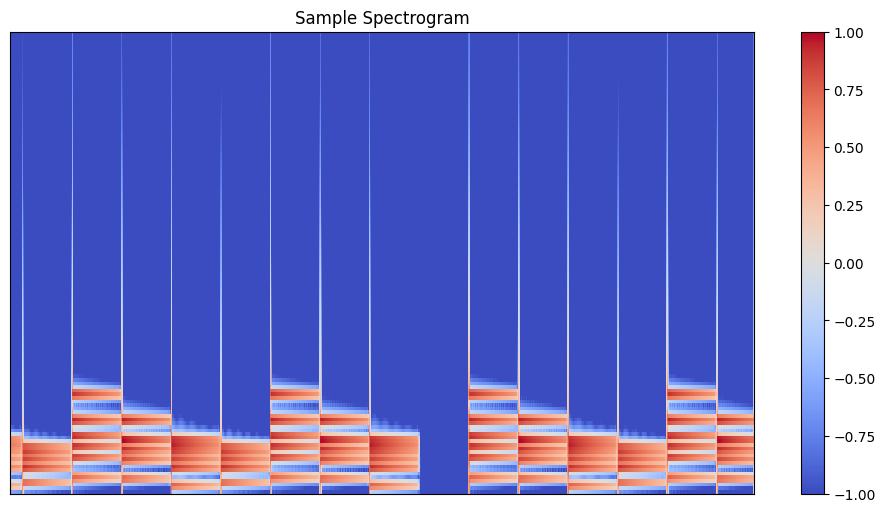


2. Creating dataset...
Kept 56 valid spectrograms
56 samples in dataset

3. Training VAE model...
Training new model...
Epoch 1/200, Loss: 157305.0647, LR: 1.00e-05
Epoch 2/200, Loss: 136626.0357, LR: 1.00e-05
Epoch 3/200, Loss: 118214.6094, LR: 1.00e-05
Epoch 4/200, Loss: 103987.9844, LR: 1.00e-05
Epoch 5/200, Loss: 93645.8795, LR: 1.00e-05
Epoch 6/200, Loss: 84734.8627, LR: 1.00e-05
Epoch 7/200, Loss: 77391.0647, LR: 1.00e-05
Epoch 8/200, Loss: 70648.2054, LR: 1.00e-05
Epoch 9/200, Loss: 65414.3795, LR: 1.00e-05
Epoch 10/200, Loss: 60346.3114, LR: 1.00e-05
Epoch 11/200, Loss: 56602.9615, LR: 1.00e-05
Epoch 12/200, Loss: 52959.1390, LR: 1.00e-05
Epoch 13/200, Loss: 49553.3292, LR: 1.00e-05
Epoch 14/200, Loss: 47075.9241, LR: 1.00e-05
Epoch 15/200, Loss: 44512.6183, LR: 1.00e-05
Epoch 16/200, Loss: 42264.1998, LR: 1.00e-05
Epoch 17/200, Loss: 40264.4436, LR: 1.00e-05
Epoch 18/200, Loss: 38438.8627, LR: 1.00e-05
Epoch 19/200, Loss: 36386.9431, LR: 1.00e-05
Epoch 20/200, Loss: 34471.422

In [34]:
# ===== STEP 6: MAIN EXECUTION =====
print("=== K-pop Unconditioned Generation Pipeline ===")

# Step 1: Process MIDI data
print("\n1. Processing MIDI data...")
processor = MidiDataProcessor()

# Check if processed data exists
if os.path.exists("processed_spectrograms.pkl"):
    print("Loading existing processed data...")
    with open("processed_spectrograms.pkl", 'rb') as f:
        spectrograms = pickle.load(f)
else:
    print("Processing MIDI files...")
    spectrograms = processor.process_dataset()

print(f"Dataset shape: {spectrograms.shape}")

# After loading/processing spectrograms, add this check:
print("Spectrogram stats:")
print(f"Min: {spectrograms.min()}, Max: {spectrograms.max()}")
print(f"NaN values: {np.isnan(spectrograms).sum()}")
print(f"Inf values: {np.isinf(spectrograms).sum()}")

# Add this after processing
plt.figure(figsize=(12, 6))
librosa.display.specshow(spectrograms[0], sr=22050, hop_length=512)
plt.colorbar()
plt.title('Sample Spectrogram')
plt.show()

# Step 2: Create dataset and dataloader
print("\n2. Creating dataset...")
dataset = SpectrogramDataset(spectrograms)
print(len(dataset), "samples in dataset")
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Step 3: Initialize and train model
print("\n3. Training VAE model...")
input_shape = spectrograms.shape[1:]  # (n_mels, time_steps)
model = SpectrogramVAE(
    input_shape=(128, 1292),
    latent_dim=128  # Reduced from 256
)

# Train model (or load existing)
model_path = "trained_vae_model.pth"
if os.path.exists(model_path):
    print("Loading existing model...")
    model.load_state_dict(torch.load(model_path))
else:
    print("Training new model...")
    train_vae(model, dataloader, epochs=200)
    torch.save(model.state_dict(), model_path)

# Step 4: Generate new music
print("\n4. Generating new Song tracks...")
synthesizer = AudioSynthesizer()
synthesizer.generate_audio(model, num_samples=5)

print("\n=== Generation Complete! ===")
print("Check the 'generated_songs' folder for new tracks!")

## Continuous, conditioned generation (TEMP)

K-pop Music Generation - Option 4: Continuous, Conditioned Generation (Continuous Control)

WHAT THIS ACCOMPLISHES:
- Generates K-pop music that follows specific control curves (volume, pitch, tempo, energy)
- Allows you to specify how you want the music to evolve over time
- Creates controllable music generation where you can influence musical characteristics
- Enables creation of music with specific emotional arcs or dynamic patterns

APPROACH: Conditional VAE with control signal conditioning for spectrogram generation

### Installing Dependencies

In [9]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
from pathlib import Path
import pickle
import scipy.signal
from sklearn.preprocessing import StandardScaler
import pretty_midi

In [10]:
# ===== STEP 1: CONTROL SIGNAL EXTRACTION =====

class ControlSignalExtractor:
    def __init__(self, sr=22050, hop_length=512):
        self.sr = sr
        self.hop_length = hop_length
    
    def extract_volume_curve(self, audio):
        """Extract RMS energy (volume) curve from audio"""
        rms = librosa.feature.rms(y=audio, hop_length=self.hop_length)[0]
        return rms
    
    def extract_pitch_curve(self, audio):
        """Extract fundamental frequency curve"""
        pitches, magnitudes = librosa.piptrack(y=audio, sr=self.sr, hop_length=self.hop_length)
        
        # Get the pitch with highest magnitude at each time step
        pitch_curve = []
        for t in range(pitches.shape[1]):
            index = magnitudes[:, t].argmax()
            pitch = pitches[index, t] if magnitudes[index, t] > 0.1 else 0
            pitch_curve.append(pitch)
        
        return np.array(pitch_curve)
    
    def extract_spectral_centroid(self, audio):
        """Extract spectral centroid (brightness/timbre indicator)"""
        centroid = librosa.feature.spectral_centroid(y=audio, sr=self.sr, hop_length=self.hop_length)[0]
        return centroid
    
    def extract_tempo_curve(self, audio, frame_length=2048):
        """Extract local tempo variations"""
        # Use onset strength for tempo estimation
        onset_envelope = librosa.onset.onset_strength(y=audio, sr=self.sr, hop_length=self.hop_length)
        
        # Smooth the onset envelope to get tempo-like curve
        tempo_curve = scipy.signal.savgol_filter(onset_envelope, window_length=51, polyorder=3)
        return tempo_curve
    
    def extract_midi_controls(self, midi_data):
        """Extract control signals directly from MIDI data"""
        # Get all notes
        notes = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append(note)
        
        if not notes:
            return None
        
        # Get start and end times
        start = min(note.start for note in notes)
        end = max(note.end for note in notes)
        duration = end - start
        
        # Create time grid
        time_steps = int(duration * self.sr / self.hop_length)
        times = np.linspace(start, end, time_steps)
        
        # Volume curve (velocity)
        velocity_curve = np.zeros(time_steps)
        pitch_curve = np.zeros(time_steps)
        
        for note in notes:
            # Find indices where this note is active
            note_start_idx = int((note.start - start) * time_steps / duration)
            note_end_idx = int((note.end - start) * time_steps / duration)
            
            # Apply velocity to volume curve
            velocity_curve[note_start_idx:note_end_idx] += note.velocity
            
            # Add pitch information
            pitch_curve[note_start_idx:note_end_idx] += note.pitch
        
        # Normalize volume curve
        if velocity_curve.max() > 0:
            velocity_curve = velocity_curve / velocity_curve.max()
        
        # Convert pitch to Hz and normalize
        pitch_curve = librosa.midi_to_hz(pitch_curve)
        if pitch_curve.max() > 0:
            pitch_curve = (pitch_curve - pitch_curve.min()) / (pitch_curve.max() - pitch_curve.min())
        
        # Create simple brightness and energy curves based on note density
        note_density = np.zeros(time_steps)
        for i in range(1, time_steps):
            current_time = start + i * duration / time_steps
            active_notes = sum(1 for note in notes if note.start <= current_time <= note.end)
            note_density[i] = active_notes
        
        brightness_curve = np.clip(note_density / note_density.max(), 0, 1)
        energy_curve = np.sqrt(brightness_curve)  # Simulate energy
        
        controls = {
            'volume': velocity_curve,
            'pitch': pitch_curve,
            'brightness': brightness_curve,
            'energy': energy_curve
        }
        
        return controls
    
    def extract_all_controls(self, audio_or_midi):
        """Extract all control signals from audio or MIDI"""
        if isinstance(audio_or_midi, np.ndarray):  # Audio waveform
            return self.extract_all_controls_from_audio(audio_or_midi)
        elif isinstance(audio_or_midi, str):  # MIDI file path
            try:
                midi_data = pretty_midi.PrettyMIDI(audio_or_midi)
                return self.extract_midi_controls(midi_data)
            except Exception as e:
                print(f"Error processing MIDI file: {e}")
                return None
    
    def extract_all_controls_from_audio(self, audio):
        """Extract all control signals from audio"""
        controls = {
            'volume': self.extract_volume_curve(audio),
            'pitch': self.extract_pitch_curve(audio),
            'brightness': self.extract_spectral_centroid(audio),
            'energy': self.extract_tempo_curve(audio)
        }
        
        # Ensure all curves have the same length
        min_length = min(len(curve) for curve in controls.values())
        for key in controls:
            controls[key] = controls[key][:min_length]
        
        return controls


In [11]:
# ===== STEP 2: DATA PREPROCESSING FOR CONTROL CONDITIONING =====

class ControlConditionedProcessor:
    def __init__(self, data_dir="./Data", 
                 sr=22050, n_mels=128, n_fft=2048, hop_length=512):
        self.data_dir = data_dir
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.extractor = ControlSignalExtractor(sr, hop_length)
        self.scalers = {}
    
    def midi_to_audio(self, midi_path, duration=30):
        """Convert MIDI file to audio waveform"""
        try:
            # Load MIDI file
            midi_data = pretty_midi.PrettyMIDI(midi_path)
            
            # Synthesize audio
            audio = midi_data.synthesize(fs=self.sr)
            
            # Take a fixed-length segment (e.g., 30 seconds)
            segment_length = self.sr * duration
            if len(audio) > segment_length:
                # Take middle section
                start = (len(audio) - segment_length) // 2
                audio = audio[start:start + segment_length]
            else:
                # Pad if too short
                audio = np.pad(audio, (0, max(0, segment_length - len(audio))))
            
            return audio
            
        except Exception as e:
            print(f"Error processing {midi_path}: {e}")
            return None
    
    def audio_to_melspec(self, audio):
        """Convert audio to melspectrogram with robust normalization"""
        if audio is None or len(audio) < 1024:  # Minimum audio length
            return None

        # Generate melspectrogram with safety checks
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.sr,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            fmin=20,
            fmax=self.sr//2
        )
        
        # Add small epsilon to prevent log(0)
        mel_spec = np.clip(mel_spec, a_min=1e-10, a_max=None)
        
        # Convert to dB scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Robust normalization
        eps = 1e-8
        data_min = mel_spec_db.min()
        data_max = mel_spec_db.max()
        
        if np.isclose(data_min, data_max, atol=eps):
            return None  # Skip constant spectrograms
            
        mel_spec_norm = (mel_spec_db - data_min) / (data_max - data_min + eps)
        mel_spec_norm = 2 * mel_spec_norm - 1  # Scale to [-1, 1]
        
        # Final validation
        if not np.isfinite(mel_spec_norm).all():
            return None
            
        return mel_spec_norm
    
    def process_midi_with_controls(self, midi_path, target_length=1024):
        """Process MIDI file and extract both spectrogram and control signals"""
        try:
            # Convert MIDI to audio
            audio = self.midi_to_audio(midi_path)
            if audio is None:
                return None, None
            
            # Generate melspectrogram
            mel_spec_norm = self.audio_to_melspec(audio)
            if mel_spec_norm is None:
                return None, None
            
            # Extract control signals directly from MIDI
            controls = self.extractor.extract_all_controls(midi_path)
            if controls is None:
                # Fall back to audio extraction if MIDI extraction fails
                controls = self.extractor.extract_all_controls(audio)
            
            # Resize control signals to match spectrogram time dimension
            target_time_steps = mel_spec_norm.shape[1]
            for key in controls:
                controls[key] = np.interp(
                    np.linspace(0, 1, target_time_steps),
                    np.linspace(0, 1, len(controls[key])),
                    controls[key]
                )
            
            return mel_spec_norm, controls
            
        except Exception as e:
            print(f"Error processing {midi_path}: {e}")
            return None, None
    
    def process_dataset_with_controls(self, save_path="control_conditioned_data.pkl"):
        """Process all MIDI files and extract spectrograms + control signals"""
        spectrograms = []
        all_controls = []
        midi_files = []
        
        # Find all MIDI files
        midi_files.extend(Path(self.data_dir).rglob("*.mid"))
        midi_files.extend(Path(self.data_dir).rglob("*.midi"))
        
        print(f"Found {len(midi_files)} MIDI files")
        
        for i, midi_file in enumerate(midi_files):
            if i % 10 == 0:
                print(f"Processing {i}/{len(midi_files)}")
                
            spec, controls = self.process_midi_with_controls(str(midi_file))
            if spec is not None and controls is not None:
                spectrograms.append(spec)
                all_controls.append(controls)
        
        spectrograms = np.array(spectrograms)
        print(f"Processed {len(spectrograms)} spectrograms with controls")
        print(f"Spectrogram shape: {spectrograms.shape}")
        
        # Normalize control signals across the dataset
        self._fit_control_scalers(all_controls)
        normalized_controls = self._normalize_controls(all_controls)
        
        # Save processed data
        data = {
            'spectrograms': spectrograms,
            'controls': normalized_controls,
            'scalers': self.scalers
        }
        
        with open(save_path, 'wb') as f:
            pickle.dump(data, f)
        
        return spectrograms, normalized_controls
    
    def _fit_control_scalers(self, all_controls):
        """Fit scalers for each control signal type"""
        control_types = list(all_controls[0].keys())
        
        for control_type in control_types:
            # Concatenate all values for this control type
            all_values = np.concatenate([controls[control_type] for controls in all_controls])
            
            # Fit scaler
            scaler = StandardScaler()
            scaler.fit(all_values.reshape(-1, 1))
            self.scalers[control_type] = scaler
    
    def _normalize_controls(self, all_controls):
        """Normalize control signals using fitted scalers"""
        normalized_controls = []
        
        for controls in all_controls:
            normalized = {}
            for control_type, values in controls.items():
                normalized_values = self.scalers[control_type].transform(values.reshape(-1, 1)).flatten()
                normalized[control_type] = normalized_values
            normalized_controls.append(normalized)
        
        return normalized_controls

In [12]:
# ===== STEP 3: CONTROL CONDITIONED DATASET =====

class ControlConditionedDataset(Dataset):
    def __init__(self, spectrograms, controls, control_types=['volume', 'pitch', 'brightness', 'energy']):
        self.spectrograms = torch.FloatTensor(spectrograms)
        self.control_types = control_types
        
        # Convert controls to tensors
        self.controls = []
        for control_dict in controls:
            # Stack control signals into a single tensor [n_controls, time_steps]
            control_tensor = torch.stack([
                torch.FloatTensor(control_dict[control_type]) 
                for control_type in self.control_types
            ])
            self.controls.append(control_tensor)
        
        self.controls = torch.stack(self.controls)
        
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        return self.spectrograms[idx], self.controls[idx]

In [13]:
# ===== STEP 4: CONTROL CONDITIONED VAE MODEL =====

class ControlConditionedVAE(nn.Module):
    def __init__(self, spec_shape=(128, 1292), control_dim=4, latent_dim=256, control_weight=1.0):
        super(ControlConditionedVAE, self).__init__()
        self.spec_shape = spec_shape
        self.control_dim = control_dim
        self.latent_dim = latent_dim
        self.control_weight = control_weight
        
        # Spectrogram dimensions
        self.spec_flat_size = spec_shape[0] * spec_shape[1]
        
        # Control signal processing
        self.control_processor = nn.Sequential(
            nn.Conv1d(control_dim, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(256),  # Fixed size output
            nn.Flatten(),
            nn.Linear(64 * 256, 512),
            nn.ReLU(),
            nn.Linear(512, 256)
        )
        
        # Encoder (spectrogram + control conditioning)
        self.encoder = nn.Sequential(
            nn.Linear(self.spec_flat_size + 256, 2048),  # +256 for control embedding
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
        )
        
        # Latent space
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # Decoder (latent + control conditioning)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 256, 512),  # +256 for control embedding
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, self.spec_flat_size),
            nn.Tanh()
        )
    
    def encode(self, x, controls):
        # Process controls
        control_embedding = self.control_processor(controls)
        
        # Flatten spectrogram and concatenate with control embedding
        x_flat = x.view(-1, self.spec_flat_size)
        x_with_controls = torch.cat([x_flat, control_embedding], dim=1)
        
        # Encode
        h = self.encoder(x_with_controls)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, controls):
        # Process controls
        control_embedding = self.control_processor(controls)
        
        # Concatenate latent with control embedding
        z_with_controls = torch.cat([z, control_embedding], dim=1)
        
        # Decode
        x = self.decoder(z_with_controls)
        return x.view(-1, *self.spec_shape)
    
    def forward(self, x, controls):
        mu, logvar = self.encode(x, controls)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, controls)
        return x_recon, mu, logvar

In [14]:
# ===== STEP 5: TRAINING FUNCTIONS =====

def control_vae_loss(x_recon, x, mu, logvar, controls_pred=None, controls_true=None, control_weight=0.1):
    """VAE loss with optional control signal reconstruction loss"""
    # Reconstruction loss
    recon_loss = nn.MSELoss()(x_recon, x)
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Control loss (if predicting controls)
    control_loss = 0
    if controls_pred is not None and controls_true is not None:
        control_loss = nn.MSELoss()(controls_pred, controls_true)
    
    return recon_loss + 0.001 * kl_loss + control_weight * control_loss

def train_control_vae(model, dataloader, epochs=100, lr=0.001):
    """Train the control-conditioned VAE"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (spectrograms, controls) in enumerate(dataloader):
            spectrograms = spectrograms.to(device)
            controls = controls.to(device)
            
            optimizer.zero_grad()
            
            x_recon, mu, logvar = model(spectrograms, controls)
            loss = control_vae_loss(x_recon, spectrograms, mu, logvar)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
        if (epoch + 1) % 20 == 0:
            torch.save(model.state_dict(), f'control_vae_checkpoint_epoch_{epoch+1}.pth')

In [15]:
# ===== STEP 6: CONTROL CURVE GENERATION =====

class ControlCurveGenerator:
    def __init__(self, time_steps=1292):
        self.time_steps = time_steps
    
    def generate_smooth_curve(self, start_val=0, end_val=1, curve_type='linear'):
        """Generate smooth control curves"""
        t = np.linspace(0, 1, self.time_steps)
        
        if curve_type == 'linear':
            curve = start_val + (end_val - start_val) * t
        elif curve_type == 'exponential':
            curve = start_val + (end_val - start_val) * (np.exp(3*t) - 1) / (np.exp(3) - 1)
        elif curve_type == 'logarithmic':
            curve = start_val + (end_val - start_val) * np.log(1 + 9*t) / np.log(10)
        elif curve_type == 'sine':
            curve = start_val + (end_val - start_val) * (np.sin(np.pi * t - np.pi/2) + 1) / 2
        elif curve_type == 'bell':
            curve = start_val + (end_val - start_val) * np.exp(-((t - 0.5) * 6)**2)
        else:
            curve = np.full(self.time_steps, start_val)
        
        return curve
    
    def create_control_set(self, volume_curve='linear', pitch_curve='sine', 
                          brightness_curve='bell', energy_curve='exponential'):
        """Create a set of control curves"""
        controls = {
            'volume': self.generate_smooth_curve(0.2, 0.8, volume_curve),
            'pitch': self.generate_smooth_curve(-1, 1, pitch_curve),
            'brightness': self.generate_smooth_curve(-0.5, 1.5, brightness_curve),
            'energy': self.generate_smooth_curve(0.1, 1.2, energy_curve)
        }
        return controls

In [16]:
# ===== STEP 7: CONTROLLED AUDIO SYNTHESIS =====

class ControlledAudioSynthesizer:
    def __init__(self, sr=22050, n_fft=2048, hop_length=512, n_iter=32):
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_iter = n_iter
    
    def melspec_to_audio(self, mel_spec_norm):
        """Convert normalized melspectrogram back to audio"""
        mel_spec_db = (mel_spec_norm + 1) / 2 * 80 - 80
        mel_spec = librosa.db_to_power(mel_spec_db)
        audio = librosa.feature.inverse.mel_to_audio(
            mel_spec, sr=self.sr, n_fft=self.n_fft, 
            hop_length=self.hop_length, n_iter=self.n_iter
        )
        return audio
    
    def generate_controlled_music(self, model, control_generator, scalers, 
                                num_samples=5, output_dir="controlled_kpop"):
        """Generate music with specific control curves"""
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.eval()
        
        os.makedirs(output_dir, exist_ok=True)
        
        # Define different control scenarios
        scenarios = [
            {'name': 'crescendo', 'volume': 'exponential', 'energy': 'exponential'},
            {'name': 'dramatic_arc', 'volume': 'bell', 'pitch': 'sine', 'energy': 'bell'},
            {'name': 'fade_in_out', 'volume': 'bell', 'brightness': 'bell'},
            {'name': 'rising_energy', 'energy': 'exponential', 'brightness': 'exponential'},
            {'name': 'pitch_sweep', 'pitch': 'linear', 'volume': 'linear'}
        ]
        
        with torch.no_grad():
            for i, scenario in enumerate(scenarios[:num_samples]):
                print(f"Generating scenario: {scenario['name']}")
                
                # Generate control curves
                controls = control_generator.create_control_set(
                    volume_curve=scenario.get('volume', 'linear'),
                    pitch_curve=scenario.get('pitch', 'linear'),
                    brightness_curve=scenario.get('brightness', 'linear'),
                    energy_curve=scenario.get('energy', 'linear')
                )
                
                # Normalize controls using dataset scalers
                for control_type in controls:
                    if control_type in scalers:
                        controls[control_type] = scalers[control_type].transform(
                            controls[control_type].reshape(-1, 1)
                        ).flatten()
                
                # Convert to tensor
                control_tensor = torch.stack([
                    torch.FloatTensor(controls['volume']),
                    torch.FloatTensor(controls['pitch']),
                    torch.FloatTensor(controls['brightness']),
                    torch.FloatTensor(controls['energy'])
                ]).unsqueeze(0).to(device)
                
                # Sample from latent space
                z = torch.randn(1, model.latent_dim).to(device)
                
                # Generate spectrogram
                generated_spec = model.decode(z, control_tensor)
                generated_spec = generated_spec.cpu().numpy()[0]
                
                # Convert to audio
                audio = self.melspec_to_audio(generated_spec)
                
                # Save audio
                output_path = os.path.join(output_dir, f"{scenario['name']}_controlled.wav")
                sf.write(output_path, audio, self.sr)
                
                # Save control curves and spectrogram visualization
                self._save_analysis(generated_spec, controls, scenario['name'], output_dir)
                
                print(f"Generated: {output_path}")
    
    def _save_analysis(self, spectrogram, controls, name, output_dir):
        """Save spectrogram and control curve visualizations"""
        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
        
        # Spectrogram
        librosa.display.specshow(spectrogram, sr=self.sr, hop_length=self.hop_length,
                               x_axis='time', y_axis='mel', ax=axes[0])
        axes[0].set_title(f'Generated Spectrogram: {name}')
        
        # Control curves
        time_axis = np.linspace(0, 30, len(controls['volume']))  # 30 seconds
        
        for i, (control_type, values) in enumerate(controls.items()):
            color = ['red', 'blue', 'green', 'orange'][i]
            axes[1].plot(time_axis, values, label=control_type, color=color, linewidth=2)
        
        axes[1].set_title('Control Curves')
        axes[1].set_xlabel('Time (seconds)')
        axes[1].set_ylabel('Control Value')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Control curve correlation with spectrogram energy
        spec_energy = np.mean(spectrogram, axis=0)  # Average energy per time step
        axes[2].plot(time_axis, spec_energy / np.max(spec_energy), label='Spectrogram Energy', linewidth=2)
        axes[2].plot(time_axis, controls['volume'], label='Volume Control', alpha=0.7, linewidth=2)
        axes[2].set_title('Energy vs Volume Control')
        axes[2].set_xlabel('Time (seconds)')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{name}_analysis.png"), dpi=150)
        plt.close()

In [17]:
# ===== STEP 8: MAIN EXECUTION =====
print("=== K-pop Continuous Control Generation Pipeline ===")

# Step 1: Process MIDI data with control signals
print("\n1. Processing MIDI data and extracting control signals...")
processor = ControlConditionedProcessor()

if os.path.exists("control_conditioned_data.pkl"):
    print("Loading existing processed data...")
    with open("control_conditioned_data.pkl", 'rb') as f:
        data = pickle.load(f)
    spectrograms = data['spectrograms']
    controls = data['controls']
    scalers = data['scalers']
else:
    print("Processing MIDI files with control extraction...")
    spectrograms, controls = processor.process_dataset_with_controls()
    scalers = processor.scalers

print(f"Dataset: {len(spectrograms)} spectrograms with control signals")

# Step 2: Create dataset and dataloader
print("\n2. Creating control-conditioned dataset...")
dataset = ControlConditionedDataset(spectrograms, controls)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Step 3: Initialize and train control-conditioned VAE
print("\n3. Training control-conditioned VAE...")
spec_shape = spectrograms.shape[1:]
model = ControlConditionedVAE(spec_shape=spec_shape, control_dim=4, latent_dim=256)

model_path = "control_conditioned_vae.pth"
if os.path.exists(model_path):
    print("Loading existing model...")
    model.load_state_dict(torch.load(model_path))
else:
    print("Training new model...")
    train_control_vae(model, dataloader, epochs=80)
    torch.save(model.state_dict(), model_path)

# Step 4: Generate controlled music
print("\n4. Generating music with continuous control...")
control_generator = ControlCurveGenerator(time_steps=spec_shape[1])
synthesizer = ControlledAudioSynthesizer()

synthesizer.generate_controlled_music(model, control_generator, scalers, num_samples=5)

print("\n=== Controlled Generation Complete! ===")
print("Check 'controlled_kpop' folder for:")
print("- Audio files with different control scenarios")
print("- Analysis plots showing control curves and their effects")

=== K-pop Continuous Control Generation Pipeline ===

1. Processing MIDI data and extracting control signals...
Processing MIDI files with control extraction...
Found 58 MIDI files
Processing 0/58
Processing 10/58
Processing 20/58
Processing 30/58
Processing 40/58
Processing 50/58
Processed 56 spectrograms with controls
Spectrogram shape: (56, 128, 1292)
Dataset: 56 spectrograms with control signals

2. Creating control-conditioned dataset...

3. Training control-conditioned VAE...
Training new model...


KeyboardInterrupt: 